<a href="https://colab.research.google.com/github/indrasary/tutorial_klasifikasi_empati/blob/main/lstm_empathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install tensorflow==2.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.4/294.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboar

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
import keras
import tensorflow as tf
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers

In [ ]:
# !pip3 install tensorflow-metal==0.5.0

# Config

In [ ]:
# config
TRAINING = True
# TRAINING = False

USE_GDRIVE = True
#USE_GDRIVE = False

PROJECT_DIR = "drive/MyDrive/ColabNotebooks/"
# PROJECT_DIR = "/home/alkhemi/Documents/AE-CE/"

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [ ]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [ ]:
import keras.backend as K
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU


# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# https://lazyprogrammer.me/course_files/toxic_comment_train.csv
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip


In [ ]:
if USE_GDRIVE:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data pipeline

In [ ]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join(PROJECT_DIR, "glove.6B/", "glove.6B.%sd.txt" % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...vec[EMBEDDING_DIM]
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [ ]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv(PROJECT_DIR + "train_en.csv", delimiter=';')
sentences = (train["doctor"]+";"+train["patient"]).fillna("DUMMY_VALUE").values
possible_labels = ["AE", "CE"]
targets = train[possible_labels].fillna(0).values
print(sentences[0:5])
print(targets[0:5])

Loading in comments...
['What brings you in here today?;Yeah, I have this pain in my chest'
 "OK, and where is the pain exactly? ;It's just right  over on the on the left side"
 'OK, and when did this pain start?;It started just 30 minutes ago'
 'OK, and did it just come on randomly or were you doing something strenuous?; I was just shovelling the driveway and it came on'
 "OK, and has that pain been getting worse at all over the last half an hour?;No, it just came on suddenly and it's uh, uh, I'm sorry. Yeah the pain has been there this whole time and it's gotten worse ever since it started"]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 2191 unique tokens.


In [ ]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print(data[1])

Shape of data tensor: (1347, 100)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   4   2 129  29   5  27 293
  26  22  55  99  36   5  36   5 172 231]


In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

# Creating Model

In [ ]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)
print(output[2])

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy'],
)

Building model...
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


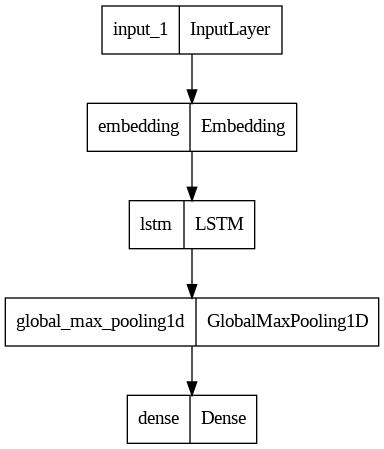

In [ ]:
plot_model(model, to_file='model.png')

In [ ]:
#from keras.models import Sequential
#from keras.layers import Dense
!pip install keras.utils.vis_utils import plot_model
#!python -c 'import keras; print(keras.__version__)'


ERROR: Could not find a version that satisfies the requirement keras.utils.vis_utils (from versions: none)
ERROR: No matching distribution found for keras.utils.vis_utils


In [ ]:
train_inputs = data[:1000]
valid_inputs = data[1000:]
train_targets = targets[:1000]
valid_targets = targets[1000:]

print(len(train_inputs))
print(len(valid_inputs))
print(len(train_targets))
print(len(valid_targets))

1000
347
1000
347


# Training

In [ ]:
print('Training model...')
r = model.fit(
  x = train_inputs,
  y = train_targets,
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_data = (valid_inputs,valid_targets)
)

Training model...
Epoch 1/5
8/8 [==============================] - 6s 361ms/step - loss: 0.3956 - accuracy: 0.9240 - val_loss: 0.2606 - val_accuracy: 0.9308
Epoch 2/5
8/8 [==============================] - 1s 100ms/step - loss: 0.2454 - accuracy: 0.9220 - val_loss: 0.2215 - val_accuracy: 0.9308
Epoch 3/5
8/8 [==============================] - 1s 91ms/step - loss: 0.2243 - accuracy: 0.9220 - val_loss: 0.2130 - val_accuracy: 0.9308
Epoch 4/5
8/8 [==============================] - 1s 87ms/step - loss: 0.2187 - accuracy: 0.9220 - val_loss: 0.2132 - val_accuracy: 0.9308
Epoch 5/5
8/8 [==============================] - 0s 62ms/step - loss: 0.2174 - accuracy: 0.9220 - val_loss: 0.2143 - val_accuracy: 0.9308


# Plot

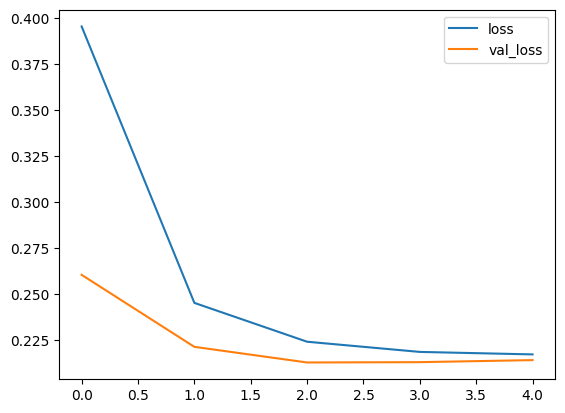

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

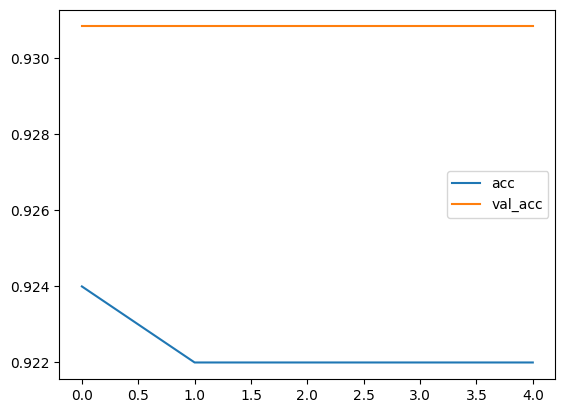

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Score

In [ ]:
p = model.predict(valid_inputs)
aucs = []
for j in range(10):
    auc = roc_auc_score(valid_targets[j], p[j])
    aucs.append(auc)
print(np.mean(aucs))
print()

11/11 [==============================] - 0s 7ms/step
1.0



In [ ]:
from keras.metrics import F1Score
valid_predictions = model.predict(valid_inputs)

f1 = F1Score(threshold=0.5)
f1.update_state(valid_targets, valid_predictions)
result = f1.result()
result.numpy()

ImportError: ignored

# Empathy Model

In [ ]:
from keras.utils import pad_sequences

class EmpathyModel():
  def __init__(self,tokenizer,model):
    super().__init__()
    self.tokenizer = tokenizer
    self.model = model

  def __call__(self, sentences):
    sequences = self.tokenizer.texts_to_sequences(sentences)
    inputs = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return self.model.predict(inputs)

In [ ]:
empathy_model = EmpathyModel(tokenizer,model)

In [ ]:
sentences[0:5]

array(['What brings you in here today?;Yeah, I have this pain in my chest',
       "OK, and where is the pain exactly? ;It's just right  over on the on the left side",
       'OK, and when did this pain start?;It started just 30 minutes ago',
       'OK, and did it just come on randomly or were you doing something strenuous?; I was just shovelling the driveway and it came on',
       "OK, and has that pain been getting worse at all over the last half an hour?;No, it just came on suddenly and it's uh, uh, I'm sorry. Yeah the pain has been there this whole time and it's gotten worse ever since it started"],
      dtype=object)

In [ ]:
dfh = tokenizer.texts_to_sequences(sentences)
print(dfh[0:5])

[[52, 338, 3, 19, 153, 119, 20, 1, 14, 38, 27, 19, 30, 134], [4, 2, 129, 29, 5, 27, 293, 26, 22, 55, 99, 36, 5, 36, 5, 172, 231], [4, 2, 37, 71, 38, 27, 232, 12, 111, 22, 379, 476, 75], [4, 2, 71, 12, 22, 164, 36, 1308, 13, 130, 3, 173, 104, 1309, 1, 32, 22, 1310, 5, 1311, 2, 12, 308, 36], [4, 2, 51, 9, 27, 24, 197, 84, 33, 45, 99, 5, 79, 420, 78, 356, 8, 12, 22, 308, 36, 702, 2, 26, 17, 17, 42, 218, 20, 5, 27, 51, 24, 53, 38, 477, 95, 2, 26, 357, 84, 131, 209, 12, 111]]


In [ ]:
empathy_model(["Hello, World",])

1/1 [==============================] - 0s 21ms/step


array([[0.42161322, 0.56411886]], dtype=float32)

# Save

In [ ]:
tokenizer_json = tokenizer.to_json()

# Writing to sjson
with open(PROJECT_DIR+"tokenizer.json", "w") as outfile:
    outfile.write(tokenizer_json)

In [ ]:
model.save(PROJECT_DIR+"model.h5",save_format="h5")

# Load and test

In [ ]:
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json
import json

# reading json
with open(PROJECT_DIR+"tokenizer.json", "r") as file:
  json_string = file.read()
  new_tokenizer = tokenizer_from_json(json_string)

new_model = load_model(PROJECT_DIR + 'model.h5')

new_empathy_model = EmpathyModel(new_tokenizer,new_model)

In [ ]:
new_empathy_model(["Hello, World"])

1/1 [==============================] - 0s 16ms/step


array([[0.42161322, 0.56411886]], dtype=float32)